# Speech to Text Datasets

> Speech to text datasets

In [ ]:
#| default_exp audio.datasets.stt

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
import torch
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import LightningDataModule, LightningModule
from matplotlib import pyplot as plt
from lhotse.dataset import BucketingSampler, OnTheFlyFeatures
from lhotse.dataset.collation import TokenCollater
from lhotse.recipes import download_librispeech, prepare_librispeech
from lhotse.dataset.vis import plot_batch
from lhotse import CutSet, RecordingSet, SupervisionSet, Fbank, FbankConfig
from pathlib import Path
from pprint import pprint

## Base class

In [ ]:
#| export

class STTDataset(Dataset):
    def __init__(self,
        tokenizer:TokenCollater, # text tokenizer
        num_mel_bins:int=80 # number of mel spectrogram bins
        ):
        self.extractor = OnTheFlyFeatures(Fbank(FbankConfig(num_mel_bins=num_mel_bins)))
        self.tokenizer = tokenizer

    def __getitem__(self, cuts: CutSet) -> dict:
        cuts = cuts.sort_by_duration()
        feats, feat_lens = self.extractor(cuts)
        tokens, token_lens = self.tokenizer(cuts)
        return {"feats_pad": feats, "ilens": feat_lens, "tokens_pad": tokens}



## LibriSpeech DataModule

In [ ]:
#| export
class LibriSpeechDataModule(LightningDataModule):
    def __init__(self,
        target_dir="/data/en", # where data will be saved / retrieved
        dataset_parts="mini_librispeech", # either full librispeech or mini subset
        output_dir="../recipes/stt/librispeech/data", # where to save manifest
        num_jobs=1 # num_jobs depending on number of cpus available
    ):
        super().__init__()
        self.save_hyperparameters(logger=False)
        self.libri = {}

    def prepare_data(self,) -> None:
        download_librispeech(target_dir=self.hparams.target_dir, dataset_parts=self.hparams.dataset_parts)

    def setup(self, stage = None):
        self.libri = prepare_librispeech(corpus_dir=Path(self.hparams.target_dir) / "LibriSpeech", output_dir=self.hparams.output_dir, num_jobs=self.hparams.num_jobs)
        if stage == "fit" or stage == None:
            self.cuts_train = CutSet.from_manifests(**self.libri["train-clean-5"])
            self.cuts_test = CutSet.from_manifests(**self.libri["dev-clean-2"])
            self.tokenizer = TokenCollater(self.cuts_train)
            self.tokenizer(self.cuts_test.subset(first=2))
            self.tokenizer.inverse(*self.tokenizer(self.cuts_test.subset(first=2)))
        if stage == "test":
            self.cuts_test = CutSet.from_manifests(**self.libri["dev-clean-2"])
            self.tokenizer = TokenCollater(self.cuts_test)
            self.tokenizer(self.cuts_test.subset(first=2))
            self.tokenizer.inverse(*self.tokenizer(self.cuts_test.subset(first=2)))

    def train_dataloader(self):
        train_sampler = BucketingSampler(self.cuts_train, max_duration=300, shuffle=True) #, bucket_method="equal_duration")
        return DataLoader(STTDataset(self.tokenizer), sampler=train_sampler, batch_size=None, num_workers=2)

    def test_dataloader(self):
        test_sampler = BucketingSampler(self.cuts_test, max_duration=400, shuffle=False) #, bucket_method="equal_duration")
        return DataLoader(STTDataset(self.tokenizer), sampler=test_sampler, batch_size=None, num_workers=2)

    @property
    def model_kwargs(self):
        return {
            "odim": len(self.tokenizer.idx2token),
        }

## Usage

In [ ]:

dm = LibriSpeechDataModule(
    target_dir="../data/en", 
    dataset_parts="mini_librispeech",
    output_dir="../data/en/LibriSpeech/dev-clean-2",
    num_jobs=1
)

In [ ]:
# skip this at export time to not waste time
# download
# dm.prepare_data()

In [ ]:
dm.setup(stage='test')

Dataset parts: 100%|██████████| 1/1 [00:00<00:00, 111.33it/s]


In [ ]:
recs = RecordingSet.from_file("../data/en/LibriSpeech/dev-clean-2/librispeech_recordings_dev-clean-2.jsonl.gz")
sup = SupervisionSet("../data/en/LibriSpeech/dev-clean-2/librispeech_supervisions_dev-clean-2.jsonl.gz")
print(len(recs),len(sup))

25 80


torch.Size([1, 1113, 80]) torch.Size([1, 163]) torch.Size([1])


<matplotlib.image.AxesImage>

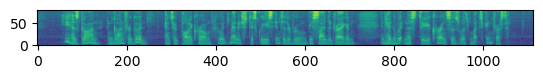

In [ ]:
test_dl = dm.test_dataloader()
b = next(iter(test_dl))
print(b["feats_pad"].shape, b["tokens_pad"].shape, b["ilens"].shape)
plt.imshow(b["feats_pad"][0].transpose(0,1), origin='lower')

# dm.tokenizer.idx2token(b["tokens_pad"][0])
# dm.tokenizer.inverse(b["tokens_pad"][0], b["ilens"][0])

CutSet(len=25) [underlying data type: <class 'dict'>]


<Axes: >

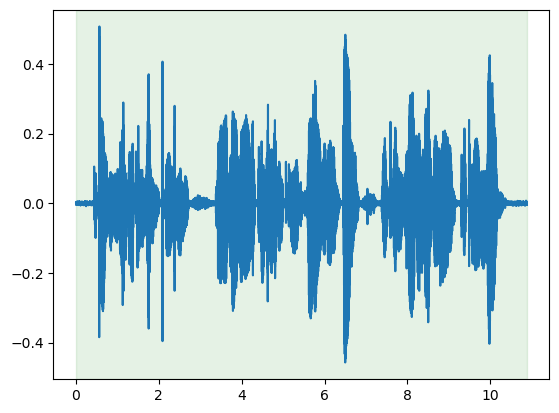

In [ ]:
print(dm.cuts_test)
cut = dm.cuts_test[0]
# pprint(cut.to_dict())
cut.plot_audio()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()